## Random Forest Classifier

#### Global Libraries

In [1]:
!pip install imbalanced-learn

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
from os.path import isfile, join
import ast
import re
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from collections import Counter

#### Load the emotions.csv dataset

In [3]:
file = 'emotions.csv'
resume_flag = False
if isfile('ssl_emotions.csv'):
    file = 'ssl_emotions.csv'
    resume_flag = True
emotions = pd.read_csv(file, encoding='latin-1')
emotions.columns

Index(['Unnamed: 0', 'background', 'aeroplane', 'bicycle', 'bird', 'boat',
       'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
       'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
       'train', 'tv/monitor', 'red', 'n_red', 'yellow', 'n_yellow', 'green',
       'n_green', 'cyan', 'n_cyan', 'blue', 'n_blue', 'magenta', 'n_magenta',
       'emotion'],
      dtype='object')

### Export log functions

In [4]:
PRINT_SECONDS = 0
session_count = 0

def trackSession():
    global session_count
    if session_count == 0:
        session_count += 1
        return True
    else:
        return False
    return False

def setSession(file, flag=True):
    now = datetime.datetime.now()
    if flag:
        file.write("\n-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))
    else:
        file.write("-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))

def endSession(flag=True):
    now = datetime.datetime.now()
    if flag:
        return "\n-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    else:
        return "-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    return ""

def delayPrint(string, seconds, f="clf_logs.log"): # n seconds delay printing
    time.sleep(seconds)
    exportLogs(string, f)
    print(string)

def exportLogs(logs, f="clf_logs.log"):
    logs += "\n"
    if(isfile(f)):
        file = open(f, "a")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()
    else:
        print("Log file does not exist!")
        print("Creating {} file...".format(f))
        file = open(f, "a+")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()

### Save data functions

In [5]:
def initCtr(iter_file="iteration_counter.txt"):
    delayPrint("Checking {} file if empty...".format(iter_file), PRINT_SECONDS)
    with open(iter_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(iter_file), PRINT_SECONDS)
            file.write("0")
            delayPrint("Done initializing {}".format(iter_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(iter_file), PRINT_SECONDS)

def initTimeData(time_labels, time_file="time.txt"):
    delayPrint("Checking {} file if empty...".format(time_file), PRINT_SECONDS)
    with open(time_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(time_file), PRINT_SECONDS)
            for x in time_labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(time_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(time_file), PRINT_SECONDS)

# load time.txt file for resuming purposes
def getTimeData(time_file="time.txt"):
    time_labels = []
    time_data = []
    with open(time_file, "r+") as file:
        delayPrint("Reading {} file...".format(time_file), PRINT_SECONDS)
        data = file.readlines()
        num_lines = len(data)
        for x in range(num_lines):
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            time_label = dt[0]
            time_dt = ast.literal_eval(dt[len(dt) - 1])
            time_labels.append(time_label)
            time_data.append(time_dt)
            delayPrint("Fetched {} list...".format(time_label), PRINT_SECONDS)
    return time_labels, time_data

def saveTimeData(time_labels, time_data, time_file="time.txt"):
    with open(time_file, "w+") as file:
        # print("Time Labels: {} Time Data: {}".format(time_labels, time_data))
        if len(time_labels) == len(time_data):
            for x in range(len(time_labels)):
                delayPrint("Saving time data...", PRINT_SECONDS)
                file.write("{} : {}\n".format(time_labels[x], time_data[x]))
            delayPrint("Saved time data...", PRINT_SECONDS)

def initScores(score_labels, score_file="scores.txt"):
    delayPrint("Checking {} file if empty...".format(score_file), PRINT_SECONDS)
    with open(score_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(score_file), PRINT_SECONDS)
            for x in score_labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(score_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(score_file), PRINT_SECONDS)

# load scores.txt file for resuming purposes
def getScores(score_file="scores.txt"):
    score_labels = []
    scores = []
    with open(score_file, "r+") as file:
        delayPrint("Reading {} file...".format(score_file), PRINT_SECONDS)
        data = file.readlines()
        num_lines = len(data)
        for x in range(num_lines):
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            score_label = dt[0]
            score = ast.literal_eval(dt[len(dt) - 1])
            score_labels.append(score_label)
            scores.append(score)
            delayPrint("Fetched {} list...".format(score_label), PRINT_SECONDS)
    return score_labels, scores

def saveScores(score_labels, scores, score_file="scores.txt"):
    with open(score_file, "w+") as file:
        # print("Score Labels: {} Scores: {}".format(score_labels, scores))
        if len(score_labels) == len(scores):
            for x in range(len(score_labels)):
                delayPrint("Saving scores...", PRINT_SECONDS)
                file.write("{} : {}\n".format(score_labels[x], scores[x]))
            delayPrint("Saved scores...", PRINT_SECONDS)

#### Remove filename column and change column headers

In [6]:
if not resume_flag:
    emotions = emotions.drop('filename', axis=1)
    emotions.columns = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
           'train', 'tv/monitor', 'red', 'n_red', 'yellow',
           'n_yellow', 'green', 'n_green', 'cyan',
           'n_cyan', 'blue', 'n_blue', 'magenta',
           'n_magenta', 'emotion']
else:
    emotions = emotions.drop("Unnamed: 0", axis=1)
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,disgust
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,AMBIGUOUS
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,disgust
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


In [7]:
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,disgust
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,AMBIGUOUS
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,disgust
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Show dataframe

In [8]:
# emotions = emotions[:616]
# emotions = emotions[:30]
# emotions['emotion'][100:len(emotions)] = np.nan
# emotions_c = pd.DataFrame()
emotions_c = emotions.copy()
emotions_c['emotion'] = ""
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,disgust
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,AMBIGUOUS
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,disgust
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Drop rows with NaN values and segregate initial dataframes with labeled and unlabeled data

In [9]:
emotions_labeled = emotions.dropna()

# fix wrong spelling
emotions_labeled = emotions_labeled.replace(["aniticipation"], "anticipation")
# emotions_labeled.at[0, 'emotion'] = "joy"
# emotions_labeled.at[1, 'emotion'] = "joy"
# emotions_labeled.at[3, 'emotion'] = "anger"
# emotions_labeled.at[5, 'emotion'] = "disgust"
# emotions_labeled.at[6, 'emotion'] = "surprise"
# emotions_labeled.at[8, 'emotion'] = "trust"
# emotions_labeled.at[9, 'emotion'] = "trust"
# emotions_labeled.at[13, 'emotion'] = "disgust"
emotions_labeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,disgust
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,AMBIGUOUS
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,disgust
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


In [10]:
# replace NaN values with empty string
# reference: https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
emotions_unlabeled = emotions.replace([np.nan], "")
emotions_unlabeled = emotions_unlabeled.drop(emotions_unlabeled[emotions_unlabeled['emotion'] != ""].index)

# adjust indices for the unlabeled set
emotions_unlabeled.index = range(len(emotions_unlabeled.index))
emotions_unlabeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion


#### Set data X and target y for the labeled data and the unlabeled data

In [11]:
X_labeled, y_labeled = emotions_labeled.drop('emotion', axis=1), emotions_labeled['emotion']
X_unlabeled, y_unlabeled = emotions_unlabeled.drop('emotion', axis=1), emotions_unlabeled['emotion']
y_labeled

0            disgust
1                joy
2            sadness
3          AMBIGUOUS
4                joy
5            disgust
6                joy
7          AMBIGUOUS
8          AMBIGUOUS
9          AMBIGUOUS
10           disgust
11               joy
12             trust
13           sadness
14           sadness
15           sadness
16           sadness
17              fear
18              fear
19         AMBIGUOUS
20         AMBIGUOUS
21           sadness
22         AMBIGUOUS
23         AMBIGUOUS
24           disgust
25           sadness
26           sadness
27      anticipation
28      anticipation
29              fear
            ...     
2970    anticipation
2971        surprise
2972         sadness
2973         disgust
2974            fear
2975         sadness
2976    anticipation
2977             joy
2978           trust
2979        surprise
2980    anticipation
2981         disgust
2982         disgust
2983        surprise
2984    anticipation
2985       AMBIGUOUS
2986         

#### Split the dataset into training and test sets

In [12]:
# X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)

#### Resampling Methods (Oversampling) - Balancing the dataset
1. Resample (oversampling) base dataset for base learner
2. Resample current dataset of every iteration in the process of fitting
3. Resample predicted dataset after SSL for final classifier

**CAUTION**: Overfitting is more likely to occur!!

In [13]:
X_smote, y_smote = SMOTE().fit_sample(X_train_labeled, y_train_labeled)
# X_smote_c = pd.DataFrame(X_smote, columns=X_.columns).copy()
# X_smote_c['emotion'] = pd.Series(y_smote)
delayPrint("Normal Distribution: {}".format(Counter(sorted(y_train_labeled))), PRINT_SECONDS)
delayPrint("Smote Distribution: {}".format(Counter(sorted(y_smote))), PRINT_SECONDS)

Normal Distribution: Counter({'joy': 441, 'sadness': 384, 'surprise': 367, 'anger': 290, 'disgust': 237, 'trust': 229, 'fear': 142, 'AMBIGUOUS': 88, 'anticipation': 72})
Smote Distribution: Counter({'AMBIGUOUS': 441, 'anger': 441, 'anticipation': 441, 'disgust': 441, 'fear': 441, 'joy': 441, 'sadness': 441, 'surprise': 441, 'trust': 441})


#### Whole process of constructing labeled data from predicted labels (Semi-supervised learning)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from operator import itemgetter
from sklearn.model_selection import GridSearchCV
# only use first default hyperparameters for experimenting only

# set hyperparameters of classifier
param_grid = {'n_estimators' : [100, 200, 500],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [1, 2],
              'min_samples_leaf' : [1, 2, 3],
              'max_features' : ["auto", "sqrt", "log2", 0.9, 0.2],
              'oob_score' : [True],
              'n_jobs' : [-1],
              'random_state' : [42]}

# rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
# rfc = RandomForestClassifier(n_estimators=500,
#                              criterion='entropy',
#                              max_leaf_nodes=16,
#                              n_jobs=-1,
#                              random_state=0)

# flag for using only base hyperparameters for all iterations
isUseBaseParams = True

time_file = "time.txt"
scores_file = "scores.txt"

# time lists
time_labels = ["Elapsed Time Iteration", "Time Passed"]
initTimeData(time_labels)
time_labels, time_data = getTimeData(time_file)
elapsed_time_list = []
elapsed_time_iter_list = time_data[0]
time_passed_list = time_data[1]

# scores lists
score_labels = ["Best Test Scores", "Best Cross-Validation Scores", "Out-of-bag Scores"]
initScores(score_labels)
score_labels, scores = getScores(scores_file)
best_score_list = scores[0]
best_cross_val_score = scores[1]
oob_score_list = scores[2]

iteration_counter = 0
start_time = datetime.datetime.now()

# print previous session
log_file = "clf_logs.log"
if isfile(log_file):
    with open(log_file, "r+") as file:
        lines = file.readlines()
        for line in lines:
            print(line)
            
delayPrint("---------- Start Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)

# define threshold parameter
threshold = 0.01

# compute number of iterations produced
emotions_labeled_len = len(emotions_labeled)
emotions_unlabeled_len = len(emotions_unlabeled)
while(emotions_labeled_len < len(emotions)):
    iteration_counter += 1
    estimated_rows = 1 if int((threshold*emotions_unlabeled_len)) < 1 else int((threshold*emotions_unlabeled_len))
    emotions_labeled_len += estimated_rows
    emotions_unlabeled_len -= estimated_rows

# show total number of models
num_models_settings = 1
for k, v in param_grid.items():
    num_models_settings *= len(v)
total_num_models = iteration_counter * num_models_settings
delayPrint("Number of iterations: {}".format(iteration_counter), PRINT_SECONDS)
delayPrint("Total number of models: {}".format(total_num_models), PRINT_SECONDS)

# set default iteration_counter
iteration_counter_file = "iteration_counter.txt"
initCtr()
    
# check saved interation_counter
with open(iteration_counter_file, "r+") as file:
    data = file.readlines()
    iteration_counter = int(data[0])
    
# loop if not all target values have emotions
# loop until everything is labeled
while(emotions['emotion'].isnull().values.any()):
    start_time_iter = datetime.datetime.now()
    
    # check saved interation_counter
    with open(iteration_counter_file, "r+") as file:
        data = file.readlines()
        iteration_counter = int(data[0])
    
    # show remaining number of models to produce
    num_models_current_settings = 1
    for k, v in param_grid.items():
        num_models_current_settings *= len(v)
    current_num_models = iteration_counter * num_models_current_settings
    rem_num_models = total_num_models - current_num_models
    delayPrint("Current number of models: {}".format(current_num_models), PRINT_SECONDS)
    delayPrint("Remaining number of models: {}".format(rem_num_models), PRINT_SECONDS)
    
    # incrementing iteration_counter
    iteration_counter += 1
        
    # grid search for random forest with 2 standard cross-validation
    # original cross-validation = 10
    model_file = 'ssl_rf_{}.pickle'.format(threshold*100) # model file name according to threshold percentage
    gs_file = 'ssl_gs_rf_{}.pickle'.format(threshold*100)
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
    if isfile(gs_file):
        delayPrint("Loading ssl gs model...", PRINT_SECONDS)
        grid_search = pickle.load(open(gs_file, 'rb'))
        best_params = grid_search.best_params_
    elif not isfile(gs_file):
        delayPrint("Doing grid search...", PRINT_SECONDS)
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
        # grid_search.fit(X_train_labeled, y_train_labeled)
        grid_search.fit(X_smote, y_smote)
        best_params = grid_search.best_params_
    
    # grid search every iteration if learning is base-iter
    if not isUseBaseParams:
        if isfile(gs_file):
            delayPrint("Doing grid search...", PRINT_SECONDS)
            grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
            grid_search.fit(X_smote, y_smote)
            best_params = grid_search.best_params_
    
    # saving grid search model
    with open(gs_file, 'wb') as file:
        delayPrint("Saving gs model...", PRINT_SECONDS)
        pickle.dump(grid_search, file)
    
    # use saved model if there is
    rfc = RandomForestClassifier()
    if isfile(model_file):
        delayPrint("Loading model...", PRINT_SECONDS)
        rfc = pickle.load(open(model_file, 'rb'))
    elif not isfile(model_file): # else-if for using only best base hyperparameters
        # comment else and unindent block to get best hyperparameters in each iteration
        # set best base parameters
        delayPrint("Using best hyperparameters...", PRINT_SECONDS)
        rfc.set_params(**best_params)

        # train the classifier
        # rfc.fit(X_train_labeled, y_train_labeled)
        rfc.fit(X_smote, y_smote)
    
    # fit every iteration if learning is base-iter
    if not isUseBaseParams:
        if isfile(model_file):
            # set best base parameters
            delayPrint("Using best hyperparameters...", PRINT_SECONDS)
            rfc.set_params(**best_params)

            # train the classifier
            # rfc.fit(X_train_labeled, y_train_labeled)
            rfc.fit(X_smote, y_smote)
    
    # save model per iteration
    with open(model_file, 'wb') as file:
        delayPrint("Saving model...", PRINT_SECONDS)
        pickle.dump(rfc, file)

    # gather class probabilities for each instance prediction
    y_pred_rfc = rfc.predict_proba(X_unlabeled)
    
    # show performance score per run
    y_pred_rfc_labeled = rfc.predict(X_test_labeled)
    # print("Accuracy score {}: {}".format(iteration_counter, accuracy_score(y_test_labeled, y_pred_rfc_labeled)))
    delayPrint("Test set score: {:.2f}".format(grid_search.score(X_test_labeled, y_test_labeled)), PRINT_SECONDS)
    delayPrint("Best parameters: {}".format(grid_search.best_params_), PRINT_SECONDS)
    delayPrint("Best cross-validation score: {:.2f}".format(grid_search.best_score_), PRINT_SECONDS)
    delayPrint("Out-of-Bag Prediction Score: {:.2f}".format(rfc.oob_score_), PRINT_SECONDS)
    
    # store scores in list
    best_score_list.append(grid_search.score(X_test_labeled, y_test_labeled))
    best_cross_val_score.append(grid_search.best_score_)
    oob_score_list.append(rfc.oob_score_)
    saveScores(score_labels, [best_score_list, best_cross_val_score, oob_score_list], scores_file)

    # get highest class probability and pass it to a list
    probas = list(map((lambda x: x.max()), y_pred_rfc))
    yprfc = list(y_pred_rfc)

    # define threshold parameter
    # threshold = 0.05

    # tuple of predicted X_instances, y_instances, and score for each instance prediction
    probas_indices = list(map((lambda x: (X_unlabeled[x['index']:x['index']+1], rfc.classes_[list(x['probas']).index(max(list(x['probas'])))], max(list(x['probas'])))), [{'index' : i, 'probas' : list(p)} for i, p in enumerate(y_pred_rfc)]))

    # sort tuple according to its score value
    sorted_probas_indices = sorted(probas_indices, key=itemgetter(2), reverse=True)

    # get top emotions from the tuple based on its threshold value
    # print("Sorted probas indices: {}".format(len(sorted_probas_indices)))
    slice_quantity = int(len(sorted_probas_indices)*threshold)
    sorted_probas_indices_threshold = sorted_probas_indices[:1 if slice_quantity < 1 else slice_quantity]

    # serpate values for X and y instances of top emotions
    # len(sorted_probas_indices_threshold)
    topy_emotions = list(map((lambda x: x[1]), sorted_probas_indices_threshold))
    # print(y_pred_rfc)
    # print(sorted_probas_indices_threshold)
    delayPrint("{}".format(topy_emotions), PRINT_SECONDS, "emotion_distribution/emotion_distribution_{}.log".format(iteration_counter))
    topx_emotions_list = sorted_probas_indices_threshold

    # instantiate new DataFrame for accumulating all X instances
    topx_emotions = pd.DataFrame()

    # gather all X predicted instances
    for x in topx_emotions_list:
        topx_emotions = topx_emotions.append(x[0])
    
    # adjust indices for topx_emotions
    # topx_emotions.index = range(len(topx_emotions.index))
    
    # remove topx_emotions from the unlabeled data
    # print(list(X_unlabeled.index))
    emotions_unlabeled = X_unlabeled.drop(X_unlabeled.index[list(topx_emotions.index)])

    # add again the target column of the universal set of unlabeled data
    emotions_unlabeled['emotion'] = None

    # set proper indices for the unlabeled set
    # emotions_unlabeled.index = range(len(emotions_labeled.index), len(emotions_labeled.index) + len(emotions_unlabeled.index))
    emotions_unlabeled.index = range(len(emotions_unlabeled.index))
    
    # add target column from the newly instantiated DataFrame along with its instances
    topx_emotions['emotion'] = topy_emotions
    top_emotions = topx_emotions

    # add the predicted instances DataFrame to the universal set of labeled data
    emotions_labeled = pd.concat([emotions_labeled, top_emotions], axis=0)

    # fix previous indices to its current position in DataFrame
    emotions_labeled.index = range(len(emotions_labeled.index))

    # combine universal labeled and unlabeled sets into one
    emotions = pd.concat([emotions_labeled, emotions_unlabeled], axis=0)

    # adjust indices for universal emotions set
    emotions.index = range(len(emotions.index))
    
    # Set data X and target y for the labeled data and the unlabeled data
    X_labeled, y_labeled = emotions_labeled.drop('emotion', axis=1), emotions_labeled['emotion']
    X_unlabeled, y_unlabeled = emotions_unlabeled.drop('emotion', axis=1), emotions_unlabeled['emotion']
    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)
    
    # re-sampled training dataset
    X_smote, y_smote = SMOTE().fit_sample(X_train_labeled, y_train_labeled)
    
    # print("Len of emotions_labeled: {}".format(len(emotions_labeled)))
    # print("Len of emotions_unlabeled: {}".format(len(emotions_unlabeled)))
    # print("Len of emotions: {}".format(len(emotions)))
    # print("Len of x_labeled:{}".format(len(X_labeled)))
    # print("Len of y_labeled:{}".format(len(y_labeled)))
    # print("Len of x_unlabeled:{}".format(len(X_unlabeled)))
    # print("Len of y_unlabeled:{}".format(len(y_unlabeled)))
    
    # show emotion distribution
    topy_em_pdser = pd.Series(topy_emotions)
    emotions_list = sorted(emotions_labeled['emotion'].unique())
    emotions_count_list = []
    for x in emotions_list:
        emotions_count_iter = len(topy_em_pdser.loc[topy_em_pdser == x])
        emotions_count = len(emotions_labeled.loc[emotions_labeled['emotion'] == x])
        emotions_count_list.append(emotions_count)
        delayPrint("Number of {}: {}".format(x, emotions_count_iter), PRINT_SECONDS, "emotion_distribution/emotion_distribution_{}.log".format(iteration_counter))
    
    # bar graph representation of emotion distribution per iteration
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    barlist = axes.bar(range(len(emotions_count_list)), emotions_count_list, color=plt.cm.Pastel1(np.arange(len(emotions_count_list))), tick_label=emotions_list)
    axes.legend(barlist, emotions_list)
    title = "Emotions Count {} Bar Graph (Semi-supervised Learning)".format(iteration_counter)
    axes.set_title(title)
    axes.set_xlabel("Emotions")
    axes.set_ylabel("Emotions Count")
    fig.set_size_inches(15, 7)
    fig.savefig("emotion_distribution/bar_graphs/"+title+".png")
    
    # time computations
    end_time_iter = datetime.datetime.now()
    elapsed_time_iter = end_time_iter - start_time_iter
    elapsed_time_iter_list.append(str(elapsed_time_iter))
    time_passed = end_time_iter - start_time
    time_passed_list.append(str(time_passed))
    # print("elapsed_time_iter_list: {}".format(elapsed_time_iter_list))
    # print("time_passed_list: {}".format(time_passed_list))
    saveTimeData(time_labels, [elapsed_time_iter_list, time_passed_list], time_file)
    delayPrint("Accuracy {} elapsed time: {}".format(iteration_counter, str(elapsed_time_iter)), PRINT_SECONDS)
    delayPrint("Time passed: {}\n".format(str(time_passed)), PRINT_SECONDS)
               
    # saving interation_counter
    with open(iteration_counter_file, "w+") as file:
        file.write("{}".format(str(iteration_counter)))
    
    # save DataFrame per iteration
    emotions.to_csv("ssl_emotions.csv", encoding='utf-8')
    

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
elapsed_time_list.append(elapsed_time)
delayPrint("---------- End Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)
delayPrint("Elapsed time: {}".format(elapsed_time), PRINT_SECONDS)

# save final DataFrame
emotions.to_csv("ssl_emotions.csv", encoding='utf-8')

# show DataFrame
emotions

Checking time.txt file if empty...
time.txt not empty...
Reading time.txt file...
Fetched Elapsed Time Iteration  list...
Fetched Time Passed  list...
Checking scores.txt file if empty...
scores.txt not empty...
Reading scores.txt file...
Fetched Best Test Scores  list...
Fetched Best Cross-Validation Scores  list...
Fetched Out-of-bag Scores  list...


-------------------- SESSION - 2018-09-30 11:05 -------------------------

Normal Distribution: Counter({'joy': 206, 'sadness': 64, 'trust': 64, 'AMBIGUOUS': 44, 'anticipation': 30, 'fear': 29, 'disgust': 17, 'anger': 13, 'surprise': 9})

Smote Distribution: Counter({'AMBIGUOUS': 206, 'anger': 206, 'anticipation': 206, 'disgust': 206, 'fear': 206, 'joy': 206, 'sadness': 206, 'surprise': 206, 'trust': 206})

Checking time.txt file if empty...

Initializing time.txt file...

Done initializing time.txt

Reading time.txt file...

Fetched Elapsed Time Iteration list...

Fetched Time Passed list...

Checking scores.txt file if empty...

Initi




Current number of models: 15120

Remaining number of models: 69480

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.74

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.42

Out-of-Bag Prediction Score: 0.41

Saving scores...

Saving scores...

Saving scores...

Saved scores...

Saving time data...

Saving time data...

Saved time data...

Accuracy 85 elapsed time: 0:00:02.028426

Time passed: 0:38:07.636294



Current number of models: 15300

Remaining number of models: 69300

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.74

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation

Time passed: 0:39:42.361880



Current number of models: 24120

Remaining number of models: 60480

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.79

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.42

Out-of-Bag Prediction Score: 0.41

Saving scores...

Saving scores...

Saving scores...

Saved scores...

Saving time data...

Saving time data...

Saved time data...

Accuracy 135 elapsed time: 0:00:01.901397

Time passed: 0:39:44.377118



Current number of models: 24300

Remaining number of models: 60300

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.78

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state


Time passed: 0:42:07.692241



Current number of models: 37620

Remaining number of models: 46980

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.83

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.42

Out-of-Bag Prediction Score: 0.41

Saving scores...

Saving scores...

Saving scores...

Saved scores...

Saving time data...

Saving time data...

Saved time data...

Accuracy 210 elapsed time: 0:00:01.770395

Time passed: 0:42:09.654013



Current number of models: 37800

Remaining number of models: 46800

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.84

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_stat

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.83

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.42

Out-of-Bag Prediction Score: 0.41

Saving scores...

Saving scores...

Saving scores...

Saved scores...

Saving time data...

Saving time data...

Saved time data...

Accuracy 302 elapsed time: 0:00:01.922050

Time passed: 0:45:05.046745



Current number of models: 54360

Remaining number of models: 30240

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.83

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.42

Out-of-Bag Prediction Score: 0.41

Saving scores...

Sav


Accuracy 384 elapsed time: 0:00:01.482423

Time passed: 0:47:29.248192



Current number of models: 69120

Remaining number of models: 15480

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.82

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.42

Out-of-Bag Prediction Score: 0.41

Saving scores...

Saving scores...

Saving scores...

Saved scores...

Saving time data...

Saving time data...

Saved time data...

Accuracy 385 elapsed time: 0:00:01.460596

Time passed: 0:47:30.820881



Current number of models: 69300

Remaining number of models: 15300

Loading ssl gs model...

Saving gs model...

Loading model...

Saving model...

Test set score: 0.82

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n

Precision Score: 0.0

Recall Score: 0.0

1. background: 0.10452

2. aeroplane: 0.00314

3. bicycle: 0.00000

4. bird: 0.03728

5. boat: 0.00223

6. bottle: 0.00424

7. bus: 0.00000

8. car: 0.00093

9. cat: 0.00775

10. chair: 0.00369

11. cow: 0.02177

12. diningtable: 0.00075

13. dog: 0.02088

14. horse: 0.01575

15. motorbike: 0.00028

16. person: 0.14542

17. potted plant: 0.00000

18. sheep: 0.00661

19. sofa: 0.00212

20. train: 0.00895

21. tv/monitor: 0.00000

22. red: 0.01750

23. n_red: 0.08343

24. yellow: 0.04458

25. n_yellow: 0.01899

26. green: 0.03398

27. n_green: 0.02164

28. cyan: 0.08344

29. n_cyan: 0.02794

30. blue: 0.08803

31. n_blue: 0.06170

32. magenta: 0.07372

33. n_magenta: 0.05875



-------------------- SESSION - 2018-10-01 15:34 -------------------------

Normal Distribution: Counter({'joy': 441, 'sadness': 384, 'surprise': 367, 'anger': 290, 'disgust': 237, 'trust': 229, 'fear': 142, 'AMBIGUOUS': 88, 'anticipation': 72})

Smote Distribution: Counter(

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,disgust
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,AMBIGUOUS
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,disgust
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Check number of emotions in dataframe

In [15]:
model_file = "ssl_rf_{}.pickle".format(threshold*100)
if isfile(model_file):
    delayPrint("Loading model...", PRINT_SECONDS)
    rfc = pickle.load(open(model_file, 'rb'))
    # emotions_list = rfc.classes_
    emotions_list = sorted(emotions['emotion'].unique())
    emotions_count_list = []
    for x in emotions_list:
        emotions_count = len(emotions.loc[emotions['emotion'] == x])
        emotions_count_list.append(emotions_count)
        delayPrint("Number of {}: {}".format(x, emotions_count), PRINT_SECONDS)

Loading model...
Number of AMBIGUOUS: 110
Number of anger: 402
Number of anticipation: 96
Number of disgust: 317
Number of fear: 176
Number of joy: 593
Number of sadness: 509
Number of surprise: 493
Number of trust: 304


#### Emotions Count Bar Graph (Post Semi-supervised Learning)

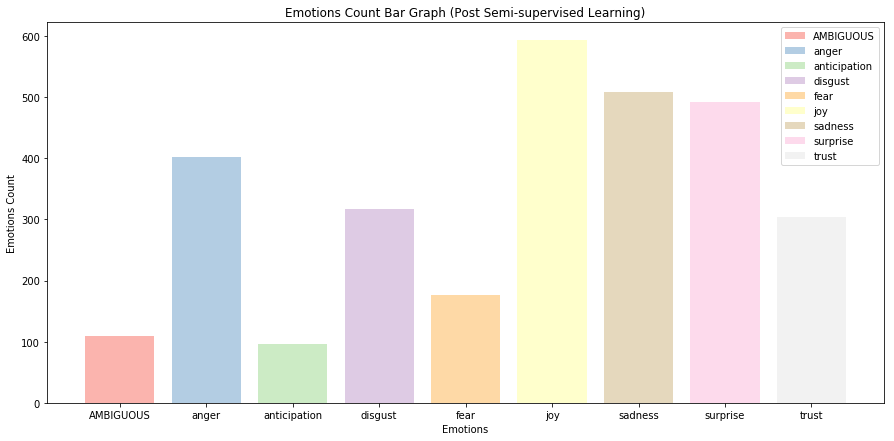

In [16]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
barlist = axes.bar(range(len(emotions_count_list)), emotions_count_list, color=plt.cm.Pastel1(np.arange(len(emotions_count_list))), tick_label=emotions_list)
axes.legend(barlist, emotions_list)
title = "Emotions Count Bar Graph (Post Semi-supervised Learning)"
axes.set_title(title)
axes.set_xlabel("Emotions")
axes.set_ylabel("Emotions Count")
fig.set_size_inches(15, 7)
fig.savefig(title+".png")

#### Comparison check if all newly made labeled set is the same with the base labeled set

In [17]:
emotions_o = emotions.copy()
emotions_o['emotion'] = "" 
df = pd.concat([emotions_o, emotions_c])
df = df.reset_index(drop=True)
df_gpby = df.groupby(list(df.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
df.reindex(idx)

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion


In [18]:
# y_pred_rfc_labeled = rfc.predict(X_labeled)
# type(y_pred_rfc_labeled)
# y_pred_rfc_labeled
# accuracy_score(np.array(y_labeled), y_pred_rfc_labeled)

In [19]:
# y_test = y_labeled.copy()
# y_test[0] = np.nan
# for x in range(len())

#### Define data X and target y for emotions data

In [20]:
X = emotions.drop('emotion', axis=1)
y = emotions['emotion']

#### Split the dataset into training and testing set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Resample final dataset (Oversampling)

In [22]:
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)
# X_smote_c = pd.DataFrame(X_smote, columns=X_.columns).copy()
# X_smote_c['emotion'] = pd.Series(y_smote)
delayPrint("Normal Distribution: {}".format(Counter(sorted(y_train))), PRINT_SECONDS)
delayPrint("Smote Distribution: {}".format(Counter(sorted(y_smote))), PRINT_SECONDS)

Normal Distribution: Counter({'joy': 432, 'sadness': 390, 'surprise': 373, 'anger': 299, 'disgust': 235, 'trust': 234, 'fear': 127, 'AMBIGUOUS': 85, 'anticipation': 75})
Smote Distribution: Counter({'AMBIGUOUS': 432, 'anger': 432, 'anticipation': 432, 'disgust': 432, 'fear': 432, 'joy': 432, 'sadness': 432, 'surprise': 432, 'trust': 432})


#### Build final model from labeled data and show essential scores to evaluate the model

In [23]:
final_param_grid = {'n_estimators' : [100, 200, 500],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [1, 2],
              'min_samples_leaf' : [1, 2, 3],
              'max_features' : ["auto", "sqrt", "log2", 0.9, 0.2],
              'oob_score' : [True],
              'n_jobs' : [-1],
              'random_state' : [42]}
final_start_time = datetime.datetime.now()
delayPrint("Start time: {}".format(final_start_time), PRINT_SECONDS)
final_model_file = "final_ssl_rf_{}.pickle".format(threshold*100)
final_gs_file = "final_gs_rf_{}.pickle".format(threshold*100)
final_grid_search = GridSearchCV(RandomForestClassifier(), final_param_grid)
if isfile(final_model_file) and isfile(final_gs_file):
    delayPrint("Loading final rfc model...", PRINT_SECONDS)
    final_rfc = pickle.load(open(final_model_file, 'rb'))
    delayPrint("Loading final grid search model...", PRINT_SECONDS)
    final_grid_search = pickle.load(open(final_gs_file, 'rb'))
else:
    final_grid_search = GridSearchCV(RandomForestClassifier(), final_param_grid, cv=10)
    # final_grid_search.fit(X_train, y_train)
    final_grid_search.fit(X_smote, y_smote)
    final_best_params = final_grid_search.best_params_
    final_rfc = RandomForestClassifier()
    final_rfc.set_params(**final_best_params)
    # final_rfc.fit(X_train, y_train)
    final_rfc.fit(X_smote, y_smote)
final_elapsed_time = datetime.datetime.now() - final_start_time
final_rfc_log_file = "final_rfc_clf.log"
delayPrint("Elapsed time: {}".format(final_elapsed_time), PRINT_SECONDS, final_rfc_log_file)
delayPrint("Test set score: {:.2f}".format(final_grid_search.score(X_test, y_test)), PRINT_SECONDS, final_rfc_log_file)
delayPrint("Best parameters: {}".format(final_grid_search.best_params_), PRINT_SECONDS, final_rfc_log_file)
delayPrint("Best cross-validation score: {:.2f}".format(final_grid_search.best_score_), PRINT_SECONDS, final_rfc_log_file)

# save final models
if not isfile(final_model_file) or not isfile(final_gs_file):
    with open(final_model_file, 'wb') as file:
        delayPrint("Saving final rfc model...", PRINT_SECONDS)
        pickle.dump(final_rfc, file)
    with open(final_gs_file, 'wb') as file:
        delayPrint("Saving final grid search model...", PRINT_SECONDS)
        pickle.dump(final_grid_search, file)

Start time: 2018-10-01 15:34:18.606491
Loading final rfc model...
Loading final grid search model...
Elapsed time: 0:00:00.068741
Test set score: 0.58
Best parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.62


#### 10 Standard cross-fold validation

In [24]:
scores = cross_val_score(final_rfc, X, y, cv=10)
# scores
delayPrint("10 standard cross-fold validation mean score: {}".format(np.mean(scores)), PRINT_SECONDS)
scores

10 standard cross-fold validation mean score: 0.573340132896611


array([0.44736842, 0.48355263, 0.54455446, 0.6013289 , 0.63333333,
       0.66      , 0.61409396, 0.65319865, 0.59259259, 0.50337838])

#### Visualization of trees

In [25]:
!pip install graphviz

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


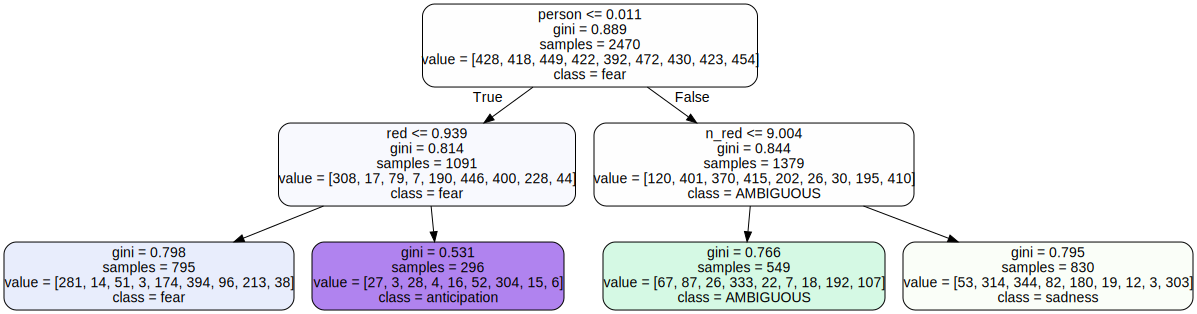

In [26]:
import graphviz
from sklearn.tree import export_graphviz
y = y.astype(np.str)
tree_path = "trees/emotions_tree{}.dot"
# export all the trees
for x in range(len(final_rfc.estimators_)):
    estimator = final_rfc.estimators_[x]
    export_graphviz(
            estimator,
            out_file=tree_path.format(x),
            feature_names=X.columns,
            class_names=y.unique(),
            rounded=True,
            filled=True
        )

with open("trees/emotions_tree0.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### Convert all .dots to .pngs

In [27]:
!pip install pydot

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
import pydot
for x in range(len(final_rfc.estimators_)):
    (graph,) = pydot.graph_from_dot_file(tree_path.format(x))
    graph.write_png('trees/emotions_tree{}.png'.format(x))

#### Classification Report

In [29]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
y2 = (y == "sadness")
y3 = cross_val_predict(final_rfc, X, y, cv=10) # y preds for whole dataset
# y2 = (y == max(dict(Counter(y3)).items(), key=itemgetter(1))[0]) # get highest count of emotions and use basis for binary values
y4 = cross_val_predict(final_rfc, X, y2, cv=10) # binary y
delayPrint(classification_report(y, y3, target_names=final_rfc.classes_), PRINT_SECONDS)

              precision    recall  f1-score   support

   AMBIGUOUS       0.00      0.00      0.00       110
       anger       0.56      0.90      0.69       402
anticipation       0.00      0.00      0.00        96
     disgust       0.61      0.52      0.56       317
        fear       0.00      0.00      0.00       176
         joy       0.49      0.70      0.58       593
     sadness       0.61      0.80      0.69       509
    surprise       0.59      0.56      0.58       493
       trust       0.90      0.30      0.45       304

 avg / total       0.53      0.57      0.52      3000



/home/butchersix/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Check number of emotions in final classifier

In [30]:
if isfile(final_model_file):
    delayPrint("Loading model...", PRINT_SECONDS)
    final_rfc = pickle.load(open(model_file, 'rb'))
    emotions_list = list(final_rfc.classes_)
    emotions_count_list = []
    for x in emotions_list:
        emotions_count = len(pd.Series(y3).loc[pd.Series(y3) == x])
        emotions_count_list.append(emotions_count)
        delayPrint("Number of {}: {}".format(x, emotions_count), PRINT_SECONDS)

Loading model...
Number of AMBIGUOUS: 0
Number of anger: 640
Number of anticipation: 0
Number of disgust: 274
Number of fear: 0
Number of joy: 844
Number of sadness: 672
Number of surprise: 468
Number of trust: 102


#### Emotions Count Bar Graph (Post Final Class Model)

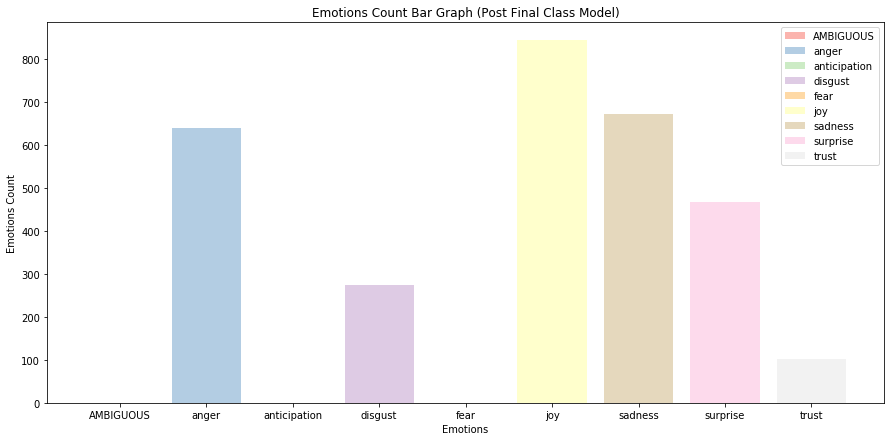

In [31]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
barlist = axes.bar(range(len(emotions_count_list)), emotions_count_list, color=plt.cm.Pastel1(np.arange(len(emotions_count_list))), tick_label=list(final_rfc.classes_))
axes.legend(barlist, emotions_list)
title = "Emotions Count Bar Graph (Post Final Class Model)"
axes.set_title(title)
axes.set_xlabel("Emotions")
axes.set_ylabel("Emotions Count")
fig.set_size_inches(15, 7)
fig.savefig(title+".png")

#### Confusion Matrix

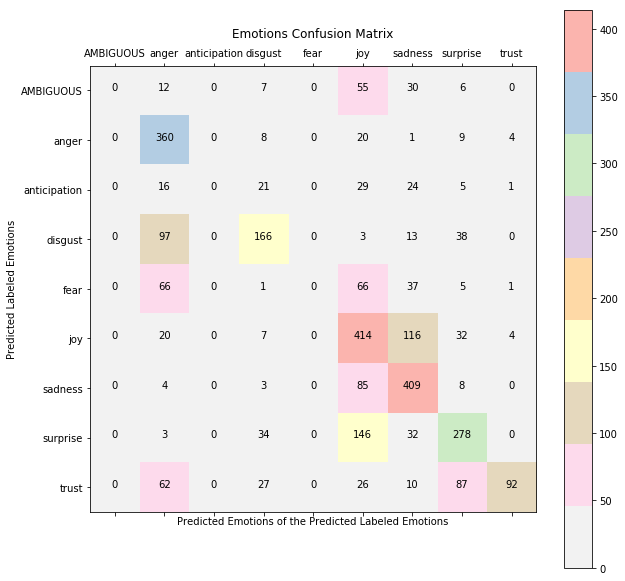

In [32]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y, y3)
plt.matshow(conf_mx, cmap=plt.cm.Pastel1.reversed())
# code for value per box
fmt = 'd'
thresh = conf_mx.max() / 2.
for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
        plt.text(j, i, format(conf_mx[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if conf_mx[i, j] > thresh else "black")
plt.ylabel("Predicted Labeled Emotions")
plt.xlabel("Predicted Emotions of the Predicted Labeled Emotions")
plt.xticks(range(len(final_rfc.classes_)), final_rfc.classes_)
plt.yticks(range(len(final_rfc.classes_)), final_rfc.classes_)
plt.colorbar()
plt.gcf().set_size_inches(10,10)
plt.title("Emotions Confusion Matrix")
plt.gcf().savefig("Emotions Confusion Matrix.png")
plt.show()
# fig, axes = plt.figure()
# fig.set_size_inches(30, 20)
# plt.show()

#### Precision vs. Recall

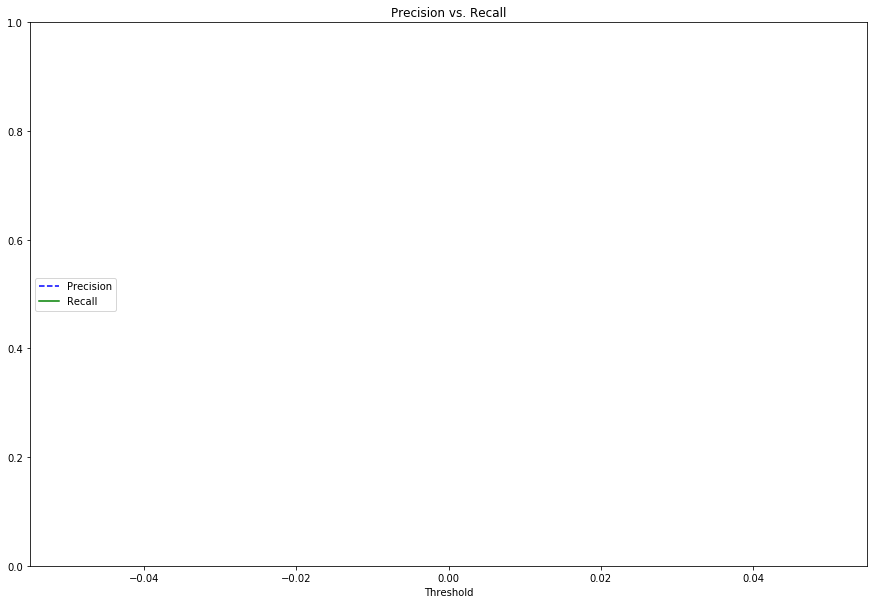

Precision Score: 0.0
Recall Score: 0.0


/home/butchersix/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
y_scores = cross_val_predict(final_rfc, X, y2, cv=10)
precisions, recalls, thresholds = precision_recall_curve(y2, y_scores)

def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.gcf().set_size_inches(15,10)
plt.title("Precision vs. Recall")
plt.gcf().savefig("PrecVsRec.png")
plt.show()
delayPrint("Precision Score: {}".format(precision_score(y2, y_scores)), PRINT_SECONDS)
delayPrint("Recall Score: {}".format(recall_score(y2, y_scores)), PRINT_SECONDS)

#### Precision against recall

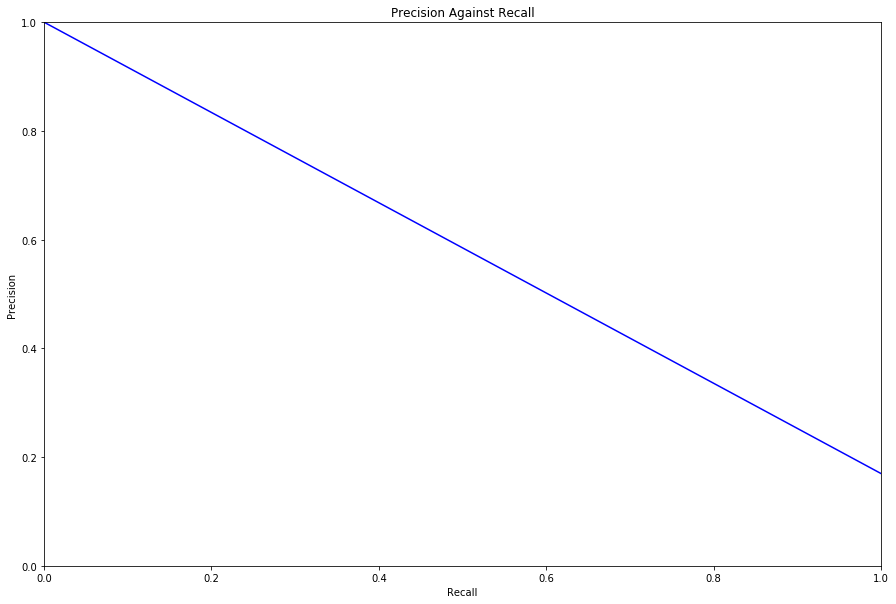

In [34]:
def plot_precision_recall(precisions, recall):
    plt.plot(recall,precisions,"b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0,1])
    plt.ylim([0,1])
    
plot_precision_recall(precisions, recalls)
plt.gcf().set_size_inches(15,10)
plt.title("Precision Against Recall")
plt.gcf().savefig("PrecAgRec.png")
plt.show()

#### ROC Curve

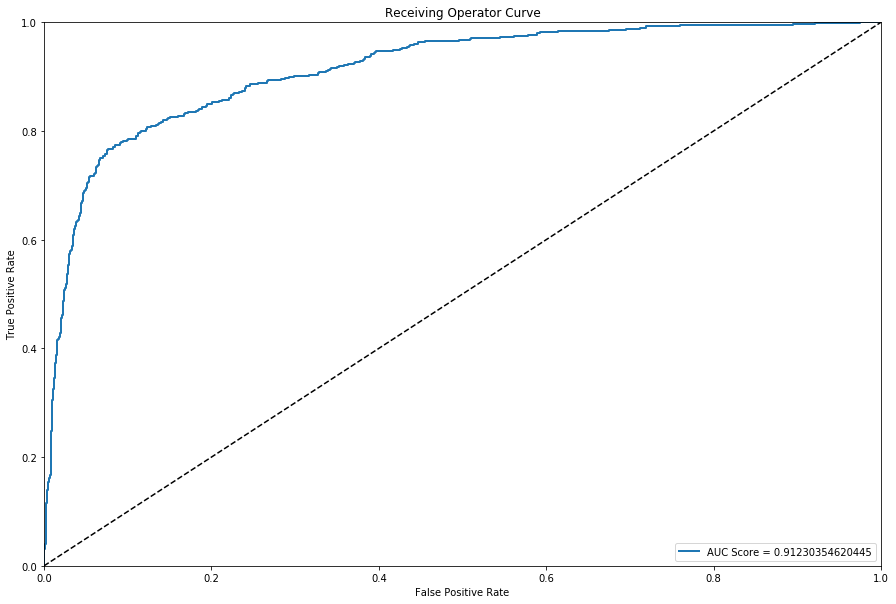

In [35]:
from sklearn.metrics import roc_auc_score
y_probas_forest = cross_val_predict(final_rfc, X, y2, cv=10, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y2, y_scores_forest)
auc_score = roc_auc_score(y2, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_forest, tpr_forest, "AUC Score = {}".format(auc_score))
plt.legend(loc="lower right")
plt.gcf().set_size_inches(15,10)
plt.title("Receiving Operator Curve")
plt.gcf().savefig("ROC.png")
plt.show()

#### Iteration Time Graph

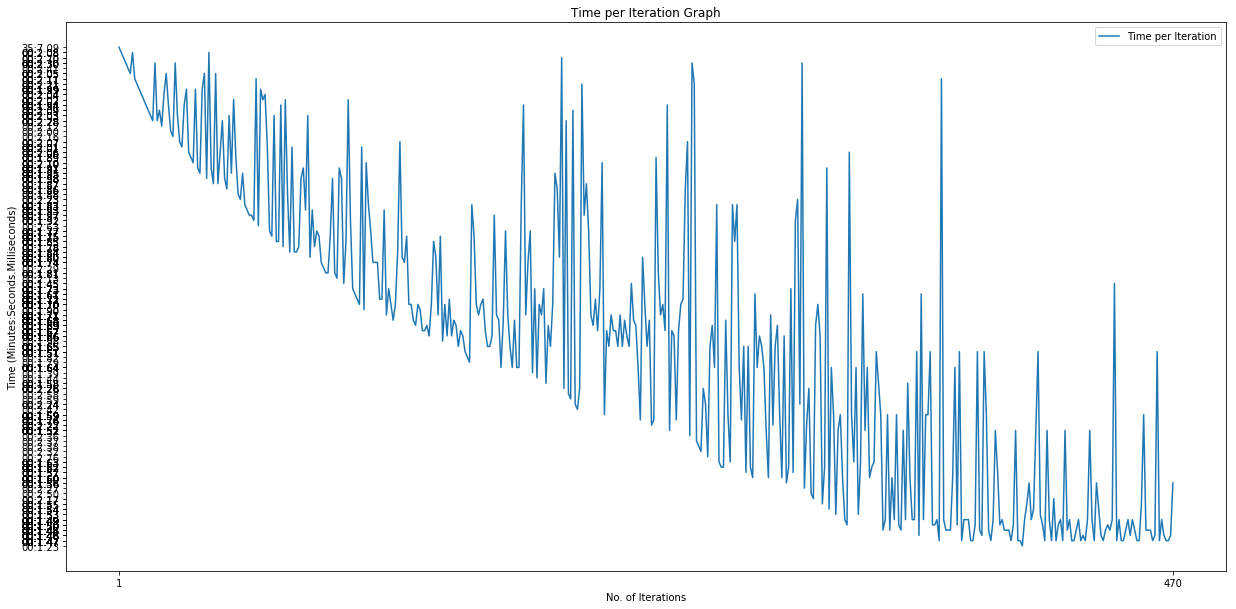

In [36]:
import matplotlib.ticker as ticker
etil = list(map((lambda x: x.split(":")[1]+":"+"{:.2f}".format(float(x.split(":")[2]))), elapsed_time_iter_list))
yticks_etil = []
# for x in range(60):
#     for y in range(60):
#         for z in range(100):
#             yticks_etil.append("{:02d}:{:02d}.{:02d}".format(x, y, z))
#             print("{:02d}:{:02d}.{:02d}".format(x, y, z))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(etil, label="Time per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(etil)
axes.invert_yaxis()
# axes.tick_params(
#     axis='y',
#     left=False,      # ticks along the bottom edge are off
#     labelleft=False) # labels along the bottom edge are off
title = "Time per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Time (Minutes:Seconds.Milliseconds)")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()

In [37]:
# X.columns.get_loc('background')
# len(X.values.flatten())

In [38]:
# X_train.values[:, [32, len(X_train.columns) - 1]]

#### Feature importances of final classifier model

In [39]:
name_list = []
for x in range(len(final_rfc.feature_importances_)):
    name = X.columns[x]
    name_list.append(name)
    delayPrint("{}. {}: {:.5f}".format(x+1, name, final_rfc.feature_importances_[x]), PRINT_SECONDS)

1. background: 0.10452
2. aeroplane: 0.00314
3. bicycle: 0.00000
4. bird: 0.03728
5. boat: 0.00223
6. bottle: 0.00424
7. bus: 0.00000
8. car: 0.00093
9. cat: 0.00775
10. chair: 0.00369
11. cow: 0.02177
12. diningtable: 0.00075
13. dog: 0.02088
14. horse: 0.01575
15. motorbike: 0.00028
16. person: 0.14542
17. potted plant: 0.00000
18. sheep: 0.00661
19. sofa: 0.00212
20. train: 0.00895
21. tv/monitor: 0.00000
22. red: 0.01750
23. n_red: 0.08343
24. yellow: 0.04458
25. n_yellow: 0.01899
26. green: 0.03398
27. n_green: 0.02164
28. cyan: 0.08344
29. n_cyan: 0.02794
30. blue: 0.08803
31. n_blue: 0.06170
32. magenta: 0.07372
33. n_magenta: 0.05875


#### Feature importances bar graph

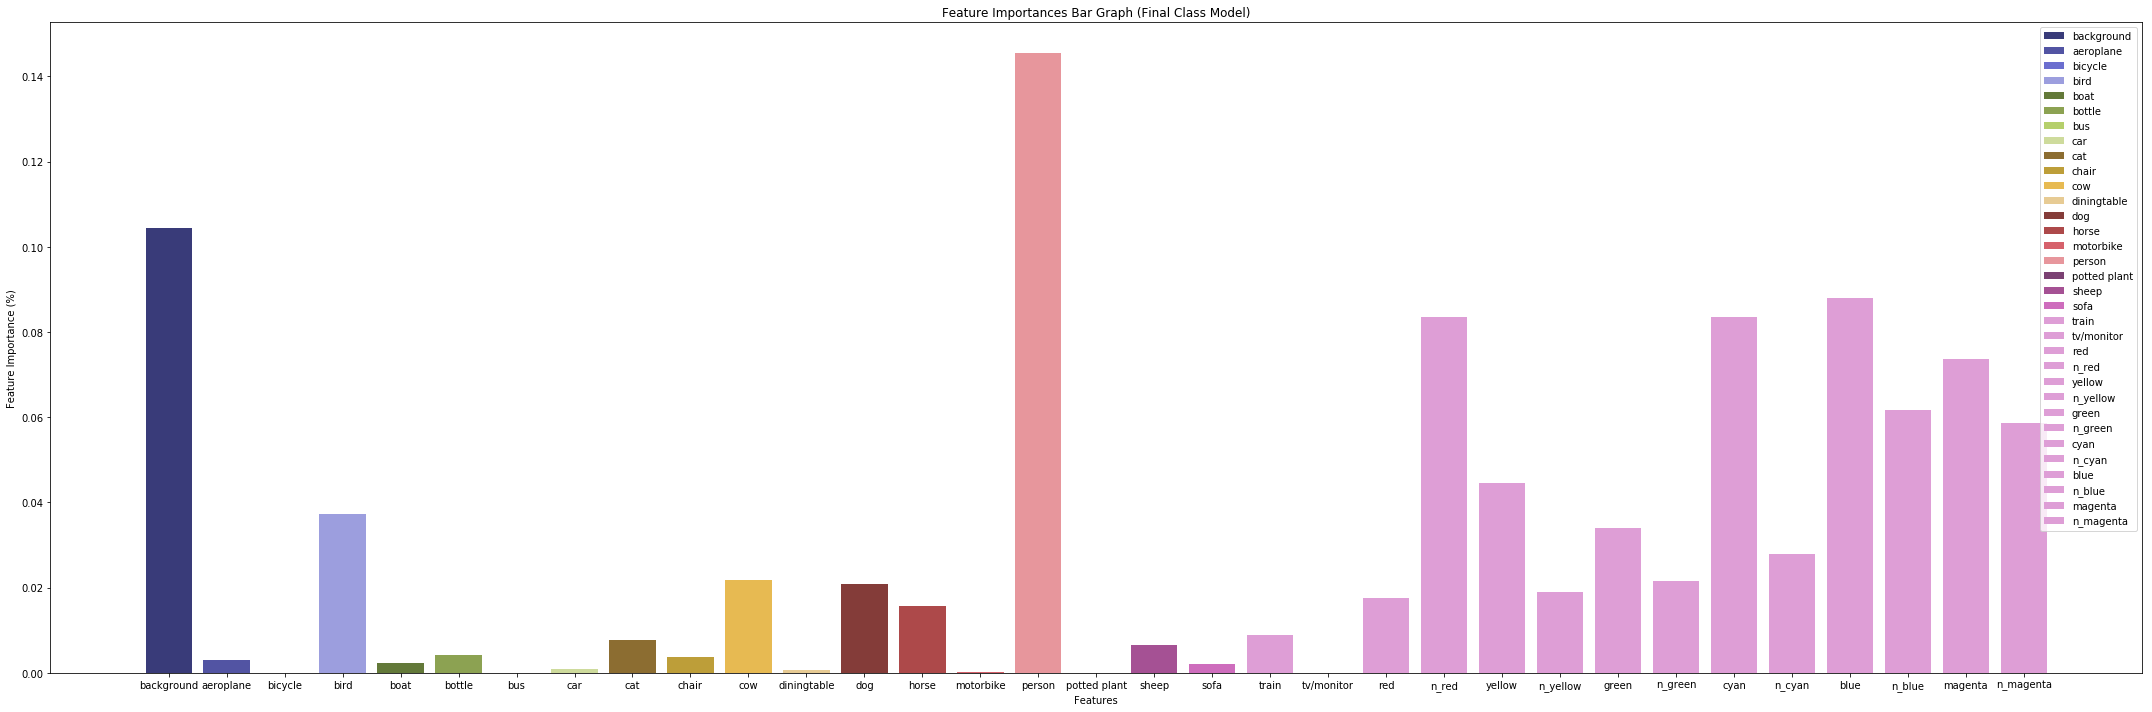

In [40]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
barlist = axes.bar(range(len(final_rfc.feature_importances_)), final_rfc.feature_importances_, color=plt.cm.tab20b(np.arange(len(final_rfc.feature_importances_))), tick_label=list(name_list))
axes.legend(barlist, name_list)
title = "Feature Importances Bar Graph (Final Class Model)"
axes.set_title(title)
axes.set_xlabel("Features")
axes.set_ylabel("Feature Importance (%)")
fig.set_size_inches(30, 10)
fig.tight_layout()
fig.savefig(title+".png")
plt.show()

#### Decision boundary plotting for each feature

In [41]:
# from mlxtend.plotting import plot_decision_regions
# dict_features = {}
# for x in X_train.columns:
#     if X_train.columns.get_loc(x) > 1:
#         dict_features.update({X_train.columns.get_loc(x) : list(X_train[x])})
# try_rfc_bp = final_rfc.get_params()
# try_rfc = RandomForestClassifier(**try_rfc_bp)
# try_y = pd.Series(list(map((lambda x: list(final_rfc.classes_).index(x)), y_train)))
# for x in X_train.columns:
#     idx = X_train.columns.get_loc(x)
#     try_rfc.fit(X_train.values[:, [idx, len(X_train.columns) - 1]], try_y)
#     fig = plt.figure()
#     axes = plot_decision_regions(X_train.values[:, [idx, len(X_train.columns) - 1]],
#                                  np.array(try_y),
#                                  clf=try_rfc,
#                                  legend=2)
#     fig.set_size_inches(15, 10)
#     rfdb = "Random Forest Decision Boundary"
#     plt.title(rfdb + " Feature {} ({}) Graph".format(idx + 1, x))
#     plt.ylabel("Emotion Class Indices")
#     if x.startswith("n_"):
#         plt.xlabel("No. of Color Instances")
#     else:
#         plt.xlabel("Feature Proportion Value")
#     figfile = "Random Forest Decision Boundaries/" + rfdb + " Feature {} ({}) Graph.png".format(idx + 1, x.replace("/", "or"))
#     if not isfile(figfile):
#         plt.gcf().savefig(figfile)
#     plt.show()

#### Best Test Score Iteration Graph

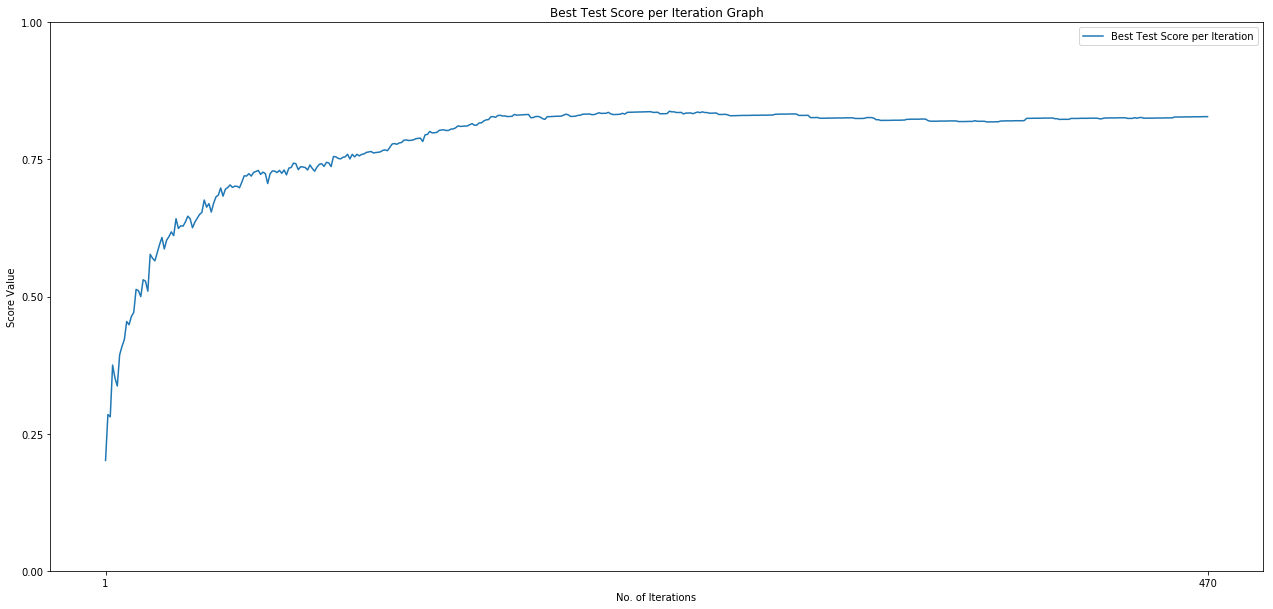

In [42]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(best_score_list, label="Best Test Score per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(np.arange(0, 1.25, 0.25))
title = "Best Test Score per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Score Value")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()

#### Best Cross-validation Scores Graph

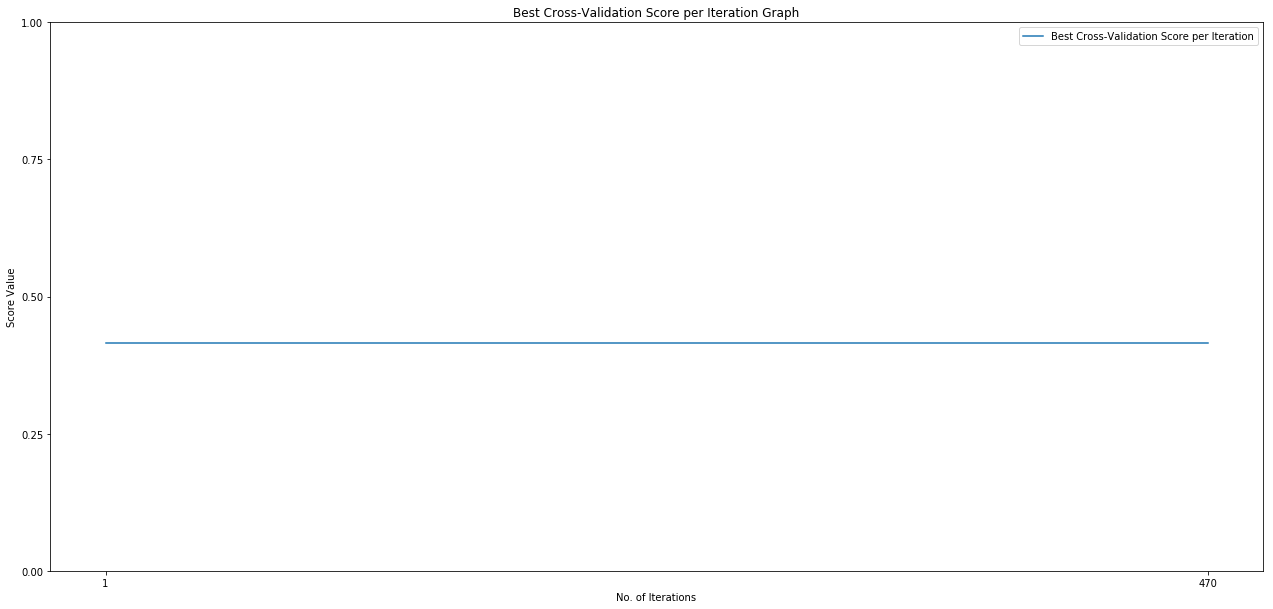

In [43]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(best_cross_val_score, label="Best Cross-Validation Score per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(np.arange(0, 1.25, 0.25))
title = "Best Cross-Validation Score per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Score Value")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()

#### Out-of-Bag Scores Graph

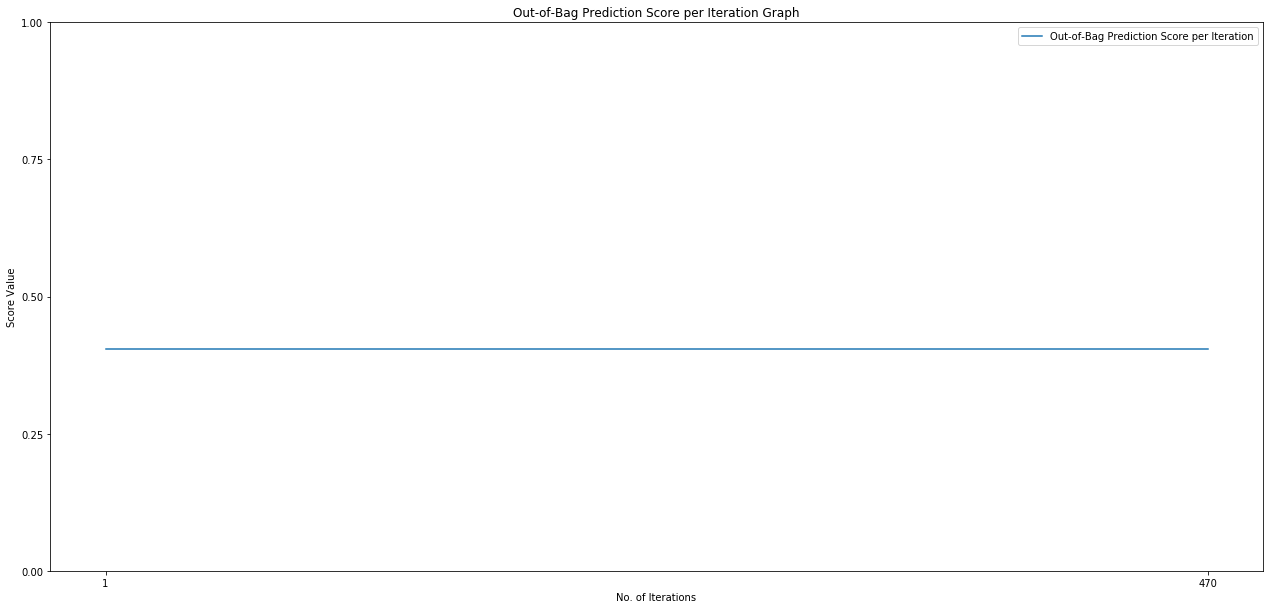

In [44]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(oob_score_list, label="Out-of-Bag Prediction Score per Iteration")
axes.legend(loc="best")
axes.set_xticks(range(iteration_counter))
axes.xaxis.set_major_locator(ticker.MultipleLocator(iteration_counter - 1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
xtick_labels[1] = '1'
xtick_labels[len(xtick_labels) - 2] = iteration_counter
axes.set_xticklabels(xtick_labels)
axes.set_yticks(np.arange(0, 1.25, 0.25))
title = "Out-of-Bag Prediction Score per Iteration Graph"
axes.set_title(title)
axes.set_xlabel("No. of Iterations")
axes.set_ylabel("Score Value")
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.gcf().savefig(title+".png")
plt.show()